In [10]:
from quantopian.research import prices, symbols
import pandas as pd


def quote(ticker, start_dt, end_dt):
    quote_close = prices(assets=symbols(ticker), start=start_dt, end=end_dt)
    return quote_close

def sma(quote, day):
    close_sma = quote.rolling(day).mean()
    return close_sma

def plot():
    pd.DataFrame({   
        ticker: q,
        'SMA20': sma(q,20),
        'SMA50': sma(q,50),
        #'SMA13': sma(q,13),
        'SMA21': sma(q,21),
        #'SMA34': sma(q,34),
        #'SMA55': sma(q,55),
        'SMA89': sma(q,89),
        'SMA200': sma(q,200)
        
    }).plot(
        title='{0} Close Price / SMA Crossover'.format(ticker)
    )


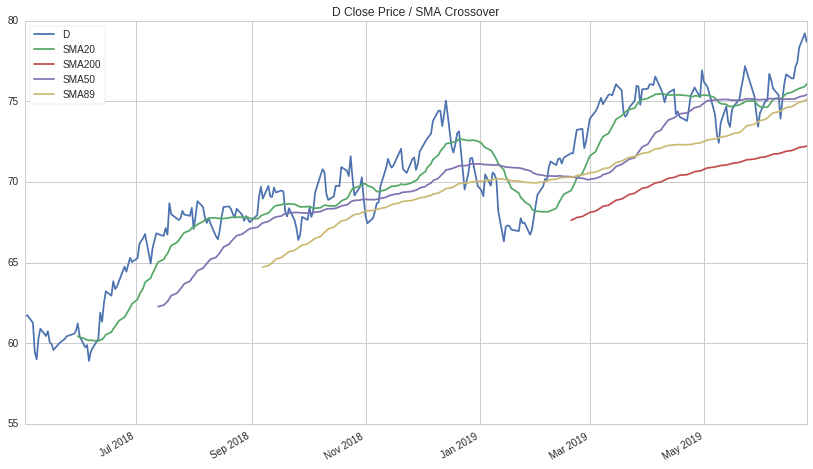

In [9]:
ticker = 'D'
q = quote(ticker, '2018-05-03', '2019-06-25')
#sma(q, 20)
#sma(q, 50)
plot()


In [143]:
from quantopian.research import returns, symbols

def quote_returns(ticker, start_dt, end_dt):
    quote_returns = returns(assets=symbols(ticker), start=start_dt, end=end_dt)
    return quote_returns

def plot():
    pd.DataFrame({   
        ticker: q
    }).plot(
        title='{0} Returns'.format(ticker)
    )


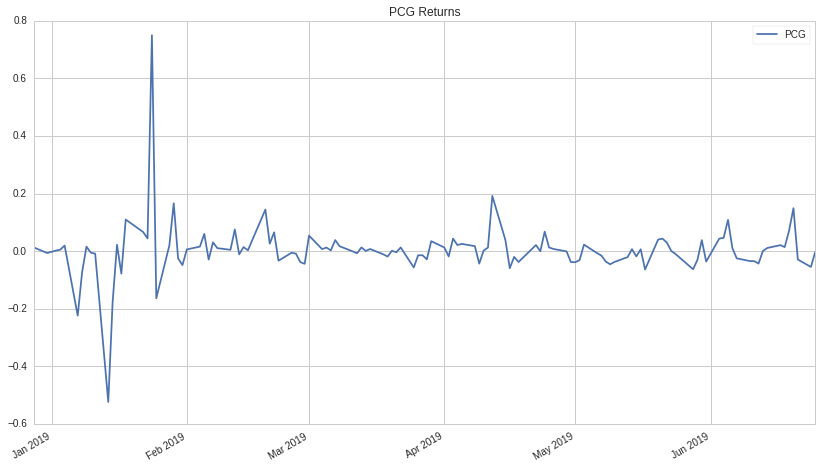

In [146]:
ticker = 'PCG'
q = quote_returns(ticker, '2018-12-28', '2019-06-25')
plot()

In [130]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data.psychsignal import stocktwits

def make_pipeline():
    returns = Returns(window_length=2)
    sentiment = stocktwits.bull_minus_bear.latest
    msg_volume = stocktwits.total_scanned_messages.latest
    return Pipeline(columns={'daily_returns': returns, 'sentiment': sentiment, 'msg_volume': msg_volume})

def output(start_dt, end_dt):
    data_output = run_pipeline(make_pipeline(), start_date=start_dt, end_date=end_dt)
    quote_output = data_output.xs(symbols(ticker), level=1)
    return quote_output.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82ffa26350>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f82ffbd7e10>], dtype=object)

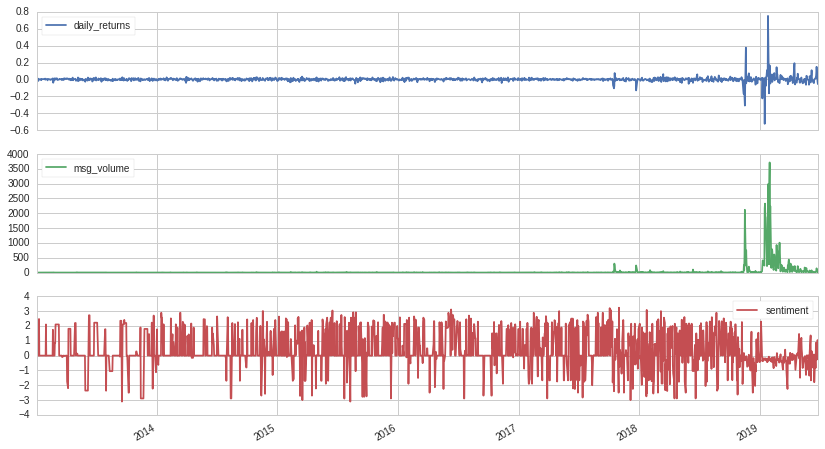

In [142]:
ticker = 'PCG'
output('2013-01-03', '2019-06-25')

In [165]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.experimental import QTradableStocksUS

def make_pipeline():
    base_universe = QTradableStocksUS()
    close_price = USEquityPricing.close.latest
    
    sentiment_score = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear], window_length=3)
    
    return Pipeline(columns={'close_price': close_price, 'sentiment_score': sentiment_score}, screen=base_universe)



In [166]:
make_pipeline()

In [173]:
from quantopian.research import run_pipeline

def output(start_dt, end_dt, length):
    pipeline_output = run_pipeline(make_pipeline(), start_date=start_dt, end_date=end_dt)
    return pipeline_output.tail(length)

In [180]:
output('2019-06-03','2019-06-26',10)

sentiment_score
2019-06-26 00:00:00+00:00 Equity(52362 [KLXE])         2.670000
                          Equity(52407 [FTDR])         2.000000
                          Equity(52408 [GTX])          1.800000
                          Equity(52424 [ELAN])         2.673333
                          Equity(52425 [FTCH])        -2.233333
                          Equity(52427 [EB])          -0.566667
                          Equity(52446 [UPWK])         0.306667
                          Equity(52450 [SVMK])         0.306667
                          Equity(52491 [GH])           0.771111
                          Equity(52494 [ESTC])         0.236667

In [234]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
import pandas as pd

def make_pipeline():
    base_universe = QTradableStocksUS()
    sentiment_score = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=3)
    top_bottom_scores = (sentiment_score.top(100) | sentiment_score.bottom(100))
    return Pipeline(columns={'sentiment_score': sentiment_score}, screen=base_universe & top_bottom_scores)

def output(start_dt, end_dt, length):
    pipeline_output = run_pipeline(make_pipeline(), start_date=start_dt, end_date=end_dt)
    asset_list = pipeline_output.index.levels[1].unique()
    asset_prices = prices(asset_list, start=start_dt, end=end_dt)
    
    factor_data = al.utils.get_clean_factor_and_forward_returns(
        factor=pipeline_output['sentiment_score'],
        prices=asset_prices,
        quantiles=2,
        periods=(1,5,10)
    )
    
    factor_data.head(length)

    mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)
    
    
    al.plotting.plot_quantile_returns_bar(
        mean_return_by_q.apply(
            al.utils.rate_of_return,
            axis=0,
            args=('1D')
        )
    )
    
    ls_factor_returns = al.performance.factor_returns(factor_data) 
    al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D', freq=pd.tseries.offsets.BDay());

Dropped 12.9% entries from factor data: 12.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


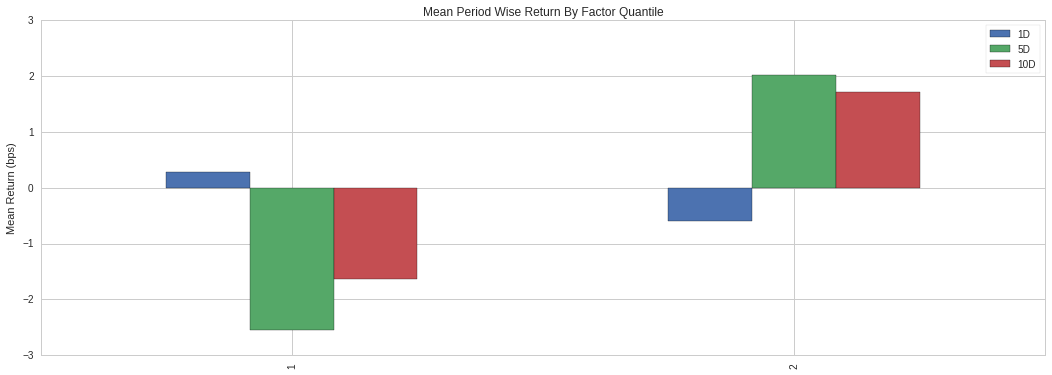

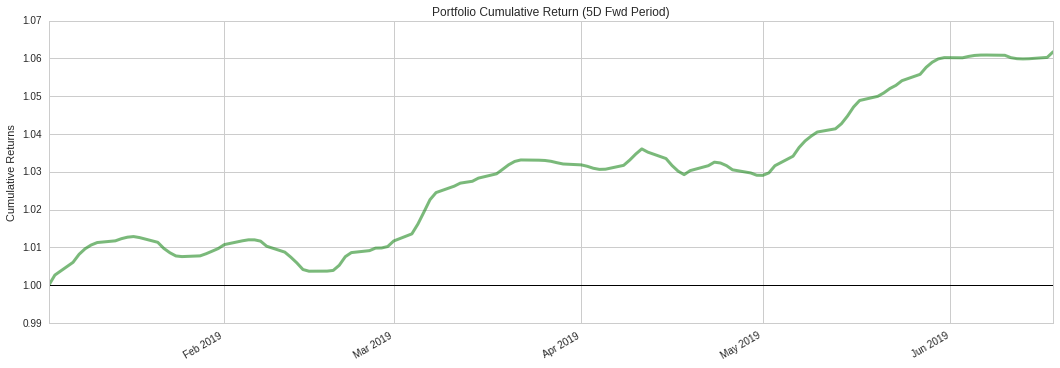

In [235]:
output('2019-01-03','2019-06-26',5)